# Clean FERC Form 1

In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Standard libraries
import logging
import sys
import os
import pathlib

# 3rd party libraries
import geopandas as gpd
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
import pickle

# Local libraries
import pudl

In [3]:
# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
# Display settings
sns.set()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 75
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [5]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq='AS'
)

In [ ]:
ferc1_years = pudl.constants.working_partitions['ferc1']['years']
ferc1_tables = ['fuel_ferc1','plants_steam_ferc1'] 
ferc1_raw_dfs = pudl.extract.ferc1.extract(
        ferc1_tables=ferc1_tables,
        ferc1_years=ferc1_years,
        pudl_settings=pudl_settings)

In [7]:
ferc1_transformed_dfs = pudl.transform.ferc1.transform(
         ferc1_raw_dfs, ferc1_tables=ferc1_tables)

Transforming raw FERC Form 1 dataframe for loading into fuel_ferc1
Transforming raw FERC Form 1 dataframe for loading into plants_steam_ferc1
Identifying distinct large FERC plants for ID assignment.
slimming fuel table
running fbp table
merging fractions with steam
filling nulls with zeros
traning classifier with default weights
generating groups of similar records
Successfully associated 22138 of 29270 (75.63%) FERC Form 1 plant records with multi-year plant entities.
Assigning IDs to multi-year FERC plant entities.
Identified 4695 orphaned FERC plant records. Adding orphans to list of plant entities.
Successfully Identified 2074 multi-year plant entities.
Found report_year=1994 3 times in plant_id_ferc1=93
Found report_year=1994 2 times in plant_id_ferc1=316
Found report_year=1995 2 times in plant_id_ferc1=316
Found report_year=1996 2 times in plant_id_ferc1=316
Found report_year=1997 2 times in plant_id_ferc1=316
Found report_year=1998 2 times in plant_id_ferc1=316
Found report_yea

In [6]:
with open('/Users/aesharpe/Desktop/ferc1_transformed.pickle', 'rb') as handle:
    ferc1_transformed_dfs = pickle.load(handle)

In [7]:
# Load the tables you'll need with some basic alterations
steam = ferc1_transformed_dfs['plants_steam_ferc1'].copy()
glue_dicts = pudl.glue.ferc1_eia.glue(ferc1=True) # For steam you'll have to mimic the glue process to get plant_id_pudl and add a column for primary fuel
steam = pd.merge(steam, glue_dicts['plants_ferc1'], on=['plant_name_ferc1', 'utility_id_ferc1'], how='left')
steam = pd.merge(steam, glue_dicts['utilities_ferc1'][['utility_id_ferc1', 'utility_name_ferc1']], on=['utility_id_ferc1'], how='left')
steam['primary_fuel'] = np.nan # Add column to document primary fuel

In [246]:
value_cols_no_cap = [
    'net_generation_mwh','avg_num_employees',
    'capex_land', 'capex_equipment', 'capex_structures', 'capex_total', 'asset_retirement_cost',
    'opex_operations', 'opex_fuel', 'opex_coolants', 'opex_steam', 'opex_steam_other', 'opex_transfer', 
    'opex_electric', 'opex_misc_power', 'opex_rents', 'opex_allowances', 'opex_engineering', 'opex_structures', 
    'opex_boiler', 'opex_plants', 'opex_misc_steam', 'opex_production_total'
]

value_cols = value_cols_no_cap + ['capacity_mw']

test_view = ['report_year', 'utility_name_ferc1', 'plant_name_ferc1', 'plant_id_pudl', 
             'plant_id_ferc1', 'primary_fuel', 'plant_type', 'record_id', 'capacity_mw']

ferc_merge_cols = ['report_year', 'utility_id_ferc1', 'plant_name_ferc1']
eia_merge_cols = ['report_date', 'plant_id_pudl', 'generator_id']

In [37]:
steam_with_fuel = pudl.analysis.fill_ferc1_fuel_gaps.impute_fuel_type(steam, pudl_out)

filling fuels with obvious names
26492 / 28514
filling in primary fuel by mmbtu
3421 / 28514
filling in eia plants with one reported fuel
2178 / 28564
filling in primary fuel by cost
1925 / 28564
filling in raw ferc1 fuels
1769 / 28564
filling in ferc plants with one fuel
1045 / 28564
filling in pudl plants with one fuel
946 / 28564
filling in manually mapped fuels
861 / 28564
front and backfilling values with the same ferc1 id
636 / 28564


In [184]:
steam_with_plant_type = pudl.analysis.fill_ferc1_fuel_gaps.impute_plant_type(steam_with_fuel)

filling plants with obvious names
761 / 28564


In [226]:
dd = pudl.analysis.fill_ferc1_fuel_gaps.flip_one_outlier_all(steam_with_plant_type)

flipping single fuel outliers
636 / 28564


In [224]:
# This'll take a minute
tt = pudl.analysis.fill_ferc1_fuel_gaps.flip_fuel_outliers_all(dd, 6)

flipping multiple fuel outliers
636 / 28564


In [255]:
test = tt[test_view + value_cols_no_cap].copy()#.to_excel('/Users/aesharpe/')
test['primary_fuel'] = test.primary_fuel.replace({np.nan:'unknown'})
test.to_excel('/Users/aesharpe/Desktop/full_fuel_df.xlsx')

In [257]:
len(tt[tt['primary_fuel'].isna()].utility_id_ferc1.unique())

53

#### Functions

In [ ]:
# Leftover net generation calculation stuff

# Combine fuel type from 860 with net generation from 923 to get fuel type and net generation
net_gen_fuel = (
    pd.merge(gens, net_gen[eia_merge_cols+['net_generation_mwh']], on=eia_merge_cols, how='outer')
    .assign(
        # Get plant net generation sums
        plant_net_gen=lambda x: (
            x.groupby(['report_date', 'plant_id_pudl']).net_generation_mwh.transform('sum')),
        # Calculate the portion of net generation that each row is responsible for
        gen_pct=lambda x: (
            x.net_generation_mwh / x.plant_net_gen * 100)
    )
)

# Calculate the sum portion of net generation attributable to each fuel type 
net_gen_fuel_sum = (
    net_gen_fuel.groupby(['report_date', 'plant_id_pudl', 'fuel_type_code_pudl'])['gen_pct']
    .sum()
    .reset_index()
    # Create flag to distinguish between rows that have more than one fuel (duplicates)
    .assign(dup=lambda x: x.duplicated(subset=['report_date', 'plant_id_pudl'], keep=False))
)

# Keep rows with only one fuel
one_fuel_eia = (
    net_gen_fuel_sum[~net_gen_fuel_sum['dup']].copy()
    .rename(columns={'fuel_type_code_pudl': 'primary_fuel_type_eia'})
    .assign(
        report_year=lambda x: x.report_date.dt.year,
        primary_fuel_type_eia=lambda x: x.primary_fuel_type_eia.replace({'':np.nan, 'unknown': np.nan, 'other': np.nan}))
    .drop(['report_date', 'gen_pct', 'dup'], axis=1)
)

# Combine steam table with EIA plant primary fuel type table, add flag to note fuel type location
steam3 = (
    pd.merge(steam2, one_fuel_eia, on=['report_year', 'plant_id_pudl'], how='left')
    .pipe(_add_new_fuel_and_flag, 'primary_fuel_type_eia', flag3)
    .pipe(_check_flags)
)

## Part 1.2: Create Fuel-Technology column
Cases: 
* one outlier fuel in the midst of one ubiquetous fuel 
* more than one outlier fuel in the midst one distinct and ubiquetous fuel
* group of similarly located outliers in the midst of one ubiquetous fuel
* distinct fuel groups without outliers

In [ ]:
def flip_two_fuel_outliers(df):
    """
    Flip groups of outliers to dominant fuel (when there are two fuels AND the one of them doesn't 
    touch an edge). Also flips when there is a single fuel among many that needs flipping
    
    """
    if len(df['tech_fuel'].dropna().unique()) == 2:
        f1 = df.tech_fuel.unique()[0]
        f2 = df.tech_fuel.unique()[1]
        f1_max = df[df['tech_fuel']==f1]['count'].max()
        f1_min = df[df['tech_fuel']==f1]['count'].min()
        f2_max = df[df['tech_fuel']==f2]['count'].max()
        f2_min = df[df['tech_fuel']==f2]['count'].min()

        if f1_max > f2_max and f1_min < f2_min:
            df['tech_fuel'] = df['tech_fuel'].replace({f2:f1})
            return df
        elif f2_max > f1_max and f2_min < f1_min:
            df['tech_fuel'] = df['tech_fuel'].replace({f1:f2})
            return df
        elif len(df[df['tech_fuel']==f1])==1 and len(df[df['tech_fuel']==f2])>1:
            df['tech_fuel'] = df['tech_fuel'].replace({f1:f2})
            return df
        elif len(df[df['tech_fuel']==f2])==1 and len(df[df['tech_fuel']==f1])>1:
            df['tech_fuel'] = df['tech_fuel'].replace({f2:f1})
            return df
        else:
            return df
    else:
        return df

In [206]:
def flip_one_outlier(df, flip_col):
    """
    Flips a fuel is there are only two unique fuels besides NA.
    
    Args:
        df (pandas.DataFrame): a groupby object that you'd like to review for fuel types.
        flip_col (str): the name of the column you'd like to flip (ex: tech_fuel or primary_fuel).

    Returns:
        pandas.DataFrame: a groupby group (technically) has been fully flipped.

    """
    if len(df[f'{flip_col}'].dropna().unique()) == 2:
       
        f1 = df[f'{flip_col}'].dropna().unique()[0]
        f2 = df[f'{flip_col}'].dropna().unique()[1]
        
        if len(df[df[f'{flip_col}']==f1])==1 and len(df[df[f'{flip_col}']==f2])>1:
            df[f'{flip_col}'] = df[f'{flip_col}'].replace({f1:f2})
            return df
        elif len(df[df[f'{flip_col}']==f2])==1 and len(df[df[f'{flip_col}']==f1])>1:
            df[f'{flip_col}'] = df[f'{flip_col}'].replace({f2:f1})
            return df
        else:
            return df
    else:
        return df
        
def create_groups(df, flip_col):
    """Squish df down into group components.

    This function takes a plant_id_ferc1 group, creates a mini dataframe (fuel_swap) that contains
    one row for each fuel group and a count for how many times that fuel appeared in that group -- there 
    can be two groups of the same fuel, meaning that there were other fuel types in between.

    Args:
        df (pandas.DataFrame): a groupby object that you'd like to condense.

    Returns:
        pandas.DataFrame: a condensed version of that dataframe input grouped by
            breaks in fuel type over the years.

    """
    group = df.groupby((df[f'{flip_col}'].shift() != df[f'{flip_col}']).cumsum(), as_index=False)
    fuel_swap_df = (
        group.agg(fuel=(f'{flip_col}', 'first'), val_count=(f'{flip_col}', 'count'))
        .assign(val_count2=lambda x: x.val_count)) # Create column based on val_count column

    # Set first and last counts to NA so they are ignored.
    fuel_swap_df.loc[fuel_swap_df.index == fuel_swap_df.index.max(), 'val_count2'] = np.nan
    fuel_swap_df.loc[fuel_swap_df.index == fuel_swap_df.index.min(), 'val_count2'] = np.nan

    return group, fuel_swap_df        
        
        
def flip_fuel_outliers(df, flip_col, max_group_size):
    """
    Flip groups of fuel flanked by others.
    
    This function takes a plant_id_ferc1 group, creates a mini dataframe (fuel_swap) that contains
    one row for each fuel group and a count for how many times that fuel appeared in that group -- there 
    can be two groups of the same fuel, meaning that there were other fuel types in between. Ex: gas, 
    coal, gas, means that there was a period of years that the plant used gas, a period of time when they
    used coal, and another period of time that it whent back to coal. The data are organized by year. 
    Each of these groups will appear in this mini dataframe. 
    
    Next, the function determines which fuel groups are considered outliers. Outliers are defined as any 
    group of rows less than or equal to the max_group_size that are flanked on either side by the same fuel
    (This means that groups at the beginning or end are excluded). Outlier groups are then flipped to match 
    the fuel type on either side of the group.

    Args:
        df (pandas.DataFrame): a groupby object that you'd like to condense.
        flip_col (str): the name of the column you'd like to flip (ex: tech_fuel or primary_fuel).
        max_group_size (int): the number of rows of the same column flanked by fuel of the same type
            that you'd like to flip (ex: 3 = gas, coal, coal, coal, gas becomes all gas).
    
    Returns:
        pandas.DataFrame: a groupby group (technically) has been fully flipped.
    
    """
    
    # If the group of rows in the desired column is completely null, skip it.
    if df[f'{flip_col}'].isna().all():
        return df
    else:
        # Create a mini group
        group, fuel_swap_df = create_groups(df, flip_col)
        # Find out fuel that appears the most
        fuel_swap_df['val_count'].max()
        # Create a list of the index values of the mini group that are under the desired max group limit
        size_limit_list = list(fuel_swap_df[fuel_swap_df['val_count2'] < max_group_size + 1].index)
        # Create a list of the values under this size limit that are also flanked by the same fuel
        outlier_list = [x for x in size_limit_list if fuel_swap_df.iloc[x+1]['fuel']==fuel_swap_df.iloc[x-1]['fuel']]
        #print(list(df.plant_id_ferc1.unique()))
        #print(fuel_swap_df)
        
        # As long as the list of outliers is more than 0:
        while len(outlier_list) > 0:
            for outlier in outlier_list:
                # Identify the flanking fuel you'll replace the outliers with
                swap_fuel = fuel_swap_df.iloc[outlier+1]['fuel']
                #print(swap_fuel)
                # Replace the outliers with the flank fuel
                df.loc[df.index.isin(group.groups[outlier+1]), flip_col] = swap_fuel
                # Get rid of None values that are a relic of the switch() function in the create groups function
                df[f'{flip_col}'] = df[f'{flip_col}'].replace({None:np.nan})
                # Reset the group, fuel_swap, and outlier lists 
                group, fuel_swap_df = create_groups(df, flip_col)
                size_limit_list = list(fuel_swap_df[fuel_swap_df['val_count2'] < max_group_size + 1].index) 
                outlier_list = [x for x in size_limit_list if fuel_swap_df.iloc[x+1]['fuel']==fuel_swap_df.iloc[x-1]['fuel']]
                #print(fuel_swap_df)
                break # Break the loop so that you can see if the most recent flip changed the outliers
                # CHECK THAT THIS BREAK DOES WHAT IT IS SUPPOSED TO DO IN ALL CASES! 
        return df

In [207]:
# Create a new field to track technology based on primary_fuel (tech_fuel), track how many
# times each fuel appears in each group (fuel_amount), and index each group (count). It's very important
# That they values are then sorted by plant_id_ferc1 and report_year.
steam11 = (
    steam_with_plant_type  #[ferc_merge_cols + ['plant_id_ferc1', 'plant_type', 'primary_fuel']].copy() # makes this section easier to debug
    .drop_duplicates()
    .sort_values(['plant_id_ferc1', 'report_year'])
    .assign(
        tech_fuel = lambda x: x.groupby(['plant_id_ferc1']).primary_fuel.apply(lambda x: x.ffill().bfill())) # The second lambda is important so the groups don't back or forward fill into each other!
        #fuel_amount = lambda x: (calc_fuel_amount(x, 'primary_fuel')),
        #count = lambda x: x.groupby(x.plant_id_ferc1).cumcount())
    .groupby(['plant_id_ferc1']).apply(lambda x: flip_one_outlier(x, 'tech_fuel'))
    .groupby(['plant_id_ferc1']).apply(lambda x: flip_fuel_outliers(x, 'tech_fuel', 6))
)

KeyboardInterrupt: 

In [898]:
# Which units still have more than one fuel associated with them
steam12[steam12['fuel_amount']>1]['plant_id_ferc1'].unique()

<IntegerArray>
[   2,    3,    5,   14,   15,   44,   59,   65,   73,   74,
 ...
 1610, 1618, 1619, 1623, 1635, 1659, 1712, 1723, 1828, 1886]
Length: 150, dtype: Int64

In [899]:
# Create technology type column. Felt cute, might delete.
steam_full_fuel = (
    tt.assign(
        tech_fuel=lambda x: x.tech_fuel.fillna('unknown'),
        #plant_type=lambda x: x.plant_type.fillna('unknown'),
        #technology_type=lambda x: x.tech_fuel + '_' + x.plant_type)
)

In [901]:
# Used to look at plants with possible bad rows
test = flagged_steam[
    (flagged_steam['plant_id_pudl']==433) #
    & (flagged_steam['report_year'].isin(range(1994,2020)))
][['report_year', 'plant_name_ferc1', 'utility_id_ferc1', 'plant_type', 'primary_fuel', 'capacity_mw', 'total_type', 'plant_id_pudl', 'primary_fuel_flag', 'record_id', 'utility_name_ferc1']]
#test
#flagged_steam[(flagged_steam['plant_name_ferc1'].str.contains('new haven'))] #& (flagged_steam['report_year'].isin(range(2000,2010)))]


In [902]:
# Plants with possible bad rows
flagged_steam[(flagged_steam['plant_type']=='unknown') & (flagged_steam['total_type'].isna())]['plant_id_pudl'].unique()

array([11677, 11678,  8812, 11911, 11916, 11898, 12065, 12088, 12087,
       12080, 12084, 11906,   503,   473,   644,   511, 12090, 12091,
       12083, 12089, 12093, 12082,    40, 12303,  8913,  8466,  1019,
        4542,  9136,  9157,  9155,  1167,  8530, 11605, 11606,  9371,
        9374,  9385,  9389,  1278,  2095,   348,   497,  1272,   433,
         308,  9994,  1326,  5152,  2527, 11812,  9369,  9388])

In [1773]:
# Checking out the wierd tech type combos
test_view = ['report_year', 'plant_name_ferc1', 'utility_id_ferc1', 'plant_id_pudl', 'plant_id_ferc1', 'plant_type', 'primary_fuel', 'capacity_mw', 'net_generation_mwh', 'primary_fuel_flag', 'record_id', 'utility_name_ferc1']

# Exceptions: 
# * ferc_id 601 -- one outlier fuel (same) on either end
# * ferc_id 839 -- turns then all to oil, but the majority are still gas--just three oil at the beginning :/
# * pudl_id 284 -- has ferc_ids allll over the place
# * pudl_id 307 -- has ferc_ids allll over the place
# * ferc_id 194 -- has one for coal left at the top...could benefit from one more "stragglers" clean through
# * ferc_id 713 -- same but an oil at the bottom
# * ferc_id 190 -- still has one bb gas at the top b/c not technically a single outlier. Might be ok to make function to clean ends if there is only ONE fuel?
# * ferc_id 554 -- has NAs and two single fuels....fill get filled in with bfill() but might not be right
# * ferc_id 64 -- an interesting case where the order of which fuel gets flipped impacts the outcome...might want to employ a way to start by flipping things that aren't the majority fuel?

flagged_steam[flagged_steam['technology_type']=='nuclear_steam']#[['report_year', 'plant_name_ferc1', 'utility_id_ferc1', 'plant_type', 'primary_fuel', 'capacity_mw', 'net_generation_mwh', 'total_type', 'plant_id_pudl', 'primary_fuel_flag', 'record_id', 'utility_name_ferc1']]
test = steam8[steam8['plant_name_ferc1'].str.contains('urquhart #1 peaking')][test_view]
#test = steam8[steam8['utility_id_ferc1']==2][test_view]
#test = steam8[steam8['plant_id_pudl']==98][test_view]
#test = steam8[steam8['plant_id_ferc1'].isin([1163])][test_view]
#test.insert(7, 'test', test.primary_fuel)
#test = test.groupby(['plant_id_ferc1']).apply(lambda x: flip_one_outlier(x, 'test'))
#test['test'] = test.groupby(['plant_id_ferc1'])['test'].apply(lambda x: x.ffill().bfill())
#test = test.groupby(['plant_id_ferc1']).apply(lambda x: flip_fuel_outliers2(x, 'test', 6))
#test.drop_duplicates()

In [1019]:
flagged_steam['technology_type'].unique().tolist()

['coal_steam',
 'gas_steam',
 'nuclear_nuclear',
 'unknown_steam',
 'oil_steam',
 'gas_combustion_turbine',
 'oil_combustion_turbine',
 'gas_combined_cycle',
 'coal_combustion_turbine',
 'unknown_unknown',
 'gas_internal_combustion',
 'coal_internal_combustion',
 'oil_internal_combustion',
 'nuclear_steam',
 'nuclear_combustion_turbine',
 'oil_combined_cycle',
 'waste_steam',
 'unknown_combustion_turbine',
 'unknown_internal_combustion',
 'geothermal_geothermal',
 'hydro_steam',
 'other_combustion_turbine',
 'other_steam',
 'coal_combined_cycle',
 'wind_wind',
 'oil_unknown',
 'gas_unknown',
 'coal_unknown',
 'unknown_combined_cycle',
 'solar_photovoltaic',
 'solar_solar_thermal']

## Part 2: Flag double counting columns

* **plant total:** pudl plant totals where the plant is owned by more than one utility.
* **utility owned total:** all of the assets owned by a utility
* **utility owned plant total:** a utility's owned portion of a pudl plant
* **utility owned plant total steam:** all of the utility's steam assets within a given pudl plant
* **utility owned plant total nuclear:** all of the utility's nuclear assets within a given pudl plant
* **utility owned subtotal:** the sum of several units within a pudl plant owned by one utility
* **unit total:** the sum of a co-owned unit (sub-pudl plant id)

In [227]:
def flag_totals(steam_table):
    """Preliminarily mark the rows with total indicated in the plant name."""
    regex1 = r'(?i)tot[a-z]*' # Find anything that would resembles TOTAL in the plant name
    regex2 = '100%' # Find all names with 100% in them
    regex3 = 'ttl ' # the space at the end is important
    regex4 = r'\(all' # find any names with '(all' in them
    
    steam_table['total'] = steam_table['plant_name_ferc1'].str.contains('|'.join([regex1, regex2, regex3])) #regex4
    ser_no_octo = steam_table[steam_table['plant_name_ferc1'].str.contains('octotillo')].total == False
    steam_table['total'].update(ser_no_octo) # remove octotillio from total = True because it accidentally fits in the 'tot' regex
    
    return steam_table

In [228]:
def flag_plant_totals(df, col_name):
    
    def is_plant_total(row):
        if 'total plant' in row:
            return 'plant total'
        elif 'plant total' in row:
            return 'plant total'
        elif 'total plt' in row:
            return 'plant total'
        elif 'ttl plt' in row:
            return 'plant total'
        elif 'tot. plt.' in row:
            return 'plant total'
        elif '100%' in row:
            return 'plant total'
        elif 'general' in row and 'general electric' not in row:
            return 'utility owned total'
        else:
            return None
    
    df[col_name] = df.apply(lambda x: is_plant_total(x.plant_name_ferc1), axis=1)
    
    return df

In [229]:
def backfill_years_by_capacity(df, col_name, replace, replace_with):
    """Backfill rows based on capacity."""
    
    only_totals_df = df[df[col_name]==replace_with]
    plant_groups = only_totals_df.groupby('plant_id_pudl')
    capacity_dict = plant_groups['capacity_mw'].apply(lambda x: [x for x in list(x.unique()) if x !=0]).to_dict() # no zeros
    plants_with_totals_list = list(capacity_dict.keys())
    
    for plant_id in plants_with_totals_list:
        for capacity in capacity_dict[plant_id]:
            one_plant_df = df[df['plant_id_pudl']==plant_id].copy()
            cap_match_df = one_plant_df[one_plant_df['capacity_mw'].isin(capacity_dict[plant_id])]
            series_update = cap_match_df[col_name].replace({replace: replace_with})
            df[col_name].update(series_update) 
            
    return df

In [230]:
def compare_totals(flag_df, comp_col):
    """Sum non-total utility-plant reported values and compare to reported totals when applicable.
    
    This function takes in a DataFrame and calculates the sum value for both the plant and utility-plant
    groups on an annual basis and compares them with any reported totals. First, this function calculates
    group totals by excluding any rows flagged as totals or extraneous in the total_types row (i.e.:
    total_type.isna()). Then, it separates the DataFrame into two small DataFrames representing all
    the utility owned total rows and all of the plant total rows reported and flagged. Next, it
    compares the calculated group total against the reported group total and outputs a True/False
    boolean. The boolean flags from these small table comparisons are then subsumed into the larger 
    DataBase under the column names: utility_owned_total_flag and plant_total_flag.
    
    These columns will show users where there might be a reporting discrepancy and allows them to
    choose which value they might want to reply on for further calculation. This flag is not yet
    incorporated into the aggregation function below, but it could be!
    
    """
    def sum_no_totals(df, col):
        no_totals_df = df.loc[df['total_type'].isna()]
        return no_totals_df[col].sum()

    # Groupby utility-plant and plant
    plant_util_groups = flag_df.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl'])
    plant_groups = flag_df.groupby(['report_year', 'plant_id_pudl'])

    # Get the sum of the values in each group that are not totals
    plant_util_total_series = plant_util_groups.apply(lambda x: sum_no_totals(x, comp_col))
    plant_total_series = plant_groups.apply(lambda x: sum_no_totals(x, comp_col))

    # Take that series of sums, reset the index, and give the sum column an informative name
    util_plant_df = pd.DataFrame(plant_util_total_series).reset_index().rename(columns={0:'plant_util_total'})
    plant_df = pd.DataFrame(plant_total_series).reset_index().rename(columns={0:'plant_total'})

    # Merge the two sum columns together on utility-plant
    df = pd.merge(plant_df, util_plant_df, on=['report_year', 'plant_id_pudl'], how='outer')
    comp_totals = pd.merge(flag_df, df, on=['report_year', 'utility_id_ferc1', 'plant_id_pudl'], how='outer')
    
    # Get slices of the dataframe that represent the utility owned total rows and the plant total rows to compare with calculated totals
    util_ot = comp_totals[comp_totals['total_type']=='utility owned total'].copy()
    plant_ot = comp_totals[comp_totals['total_type']=='plant total'].copy()

    # For each dataframe, flag whether the sum of the components (calculated above) equals the reported total
    # Could make this a little more flexible (+/- 1)
    util_ot['utility_owned_total_flag'] = np.where(util_ot['capacity_mw'] == util_ot['plant_util_total'], True, False)
    plant_ot['plant_total_flag'] = np.where(plant_ot['capacity_mw'] == plant_ot['plant_total'], True, False)
    
    # Create blank columns in the original dataframe
    comp_totals[f'{comp_col}_utility_owned_total_flag'] = None
    comp_totals[f'{comp_col}_plant_total_flag'] = None

    # Update those blank columns so that the True/False values from the prior calculations are added to the correct column
    comp_totals[f'{comp_col}_utility_owned_total_flag'].update(util_ot['utility_owned_total_flag'])
    comp_totals[f'{comp_col}_plant_total_flag'].update(plant_ot['plant_total_flag'])

    return comp_totals

### **Step 2.0:** Add totals flag to the steam table

In [233]:
# Create copy of the steam table with fuel types merged in
steam_test = tt.copy()

# Flag bad/total rows
flagged_steam = (
     steam_test
     .pipe(flag_totals) # not sure this is doing anything rn....one the one below....
     .pipe(backfill_years_by_capacity, col_name='total', replace=False, replace_with=True)
     .pipe(flag_plant_totals, col_name='total_type')
     .pipe(backfill_years_by_capacity, col_name='total_type', replace=None, replace_with='plant total')
     .pipe(pudl.analysis.fill_ferc1_fuel_gaps.add_manual_values, 'total_type', '/Users/aesharpe/Desktop/manual_total_types.xlsx')
     .drop('total', axis=1)
     .assign(primary_fuel = lambda x: x.primary_fuel.fillna('unknown'))
)

In [2019]:
# Experiment with ones yet to be flagged
# common, combined, cbd, cmbd, general, all plants, &, exps.-all combustion, unknown....look for these and # 1 unit

test = flagged_steam[flagged_steam['plant_name_ferc1'].str.contains('&') & (flagged_steam['report_year']==1994)]
#test = flagged_steam[flagged_steam['plant_name_ferc1'].str.contains('saguaro')]
#flagged_steam.plant_name_ferc1.unique() # extract to excel and look for outliers.
test = flagged_steam[(flagged_steam['plant_id_pudl']==525) & (flagged_steam['report_year'].isin(range(1994,1995)))]
#test = flagged_steam[(flagged_steam['plant_id_ferc1']==1023) & (flagged_steam['report_year']==1994)]
#test = flagged_steam[(flagged_steam['utility_id_ferc1']==193) & (flagged_steam['report_year']==1994)]
#test = test[test['utility_id_ferc1']==27]

#test[ferc_merge_cols + ['record_id', 'plant_id_pudl', 'plant_id_ferc1', 'plant_type', 'total_type', 'capacity_mw', 'utility_name_ferc1']]
#test.T
#flagged_steam[flagged_steam['record_id'].str.contains('_12_138_4_1')]

In [1195]:
flagged_steam[flagged_steam['total_type']=='utility owned subtotal']['plant_id_pudl'].unique()

array([525, 556, 623])

### **Step 2.1:** Custom aggregation based on the presense of nulls and/or totals rows

In [234]:
basic_view = ['report_year', 'plant_name_ferc1', 'utility_id_ferc1', 'plant_type', 'primary_fuel', 'capacity_mw', 'total_type', 'plant_id_pudl', 'primary_fuel_flag', 'record_id', 'utility_name_ferc1']

test1_df = flagged_steam[(flagged_steam['plant_id_pudl']==123) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df1 = test1_df[basic_view + ['capex_total', 'avg_num_employees']].copy()

test2_df = flagged_steam[(flagged_steam['plant_id_pudl']==2281) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df2 = test2_df[basic_view + ['capex_total', 'avg_num_employees']].copy()

test3_df = flagged_steam[(flagged_steam['plant_id_pudl']==288) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df3 = test3_df[basic_view + ['capex_total', 'avg_num_employees']]

In [911]:
copy_df = flagged_steam.copy()
copy_df['has_a_total'] = copy_df.groupby('plant_id_pudl')['total_type'].transform(lambda x: x.notna().any())
copy_df['has_unit_total'] = copy_df.groupby('plant_id_pudl')['total_type'].transform(lambda x: x.str.contains('unit total'))
plants_with_totals = copy_df[copy_df['has_a_total']==True]
plants_with_unit_totals = copy_df[copy_df['has_unit_total']==True]

#first_go = plants_with_totals.sort_values('plant_id_pudl')['plant_id_pudl'].unique()
#test_df = plants_with_totals[plants_with_totals['plant_id_pudl']==44]

In [240]:
# DOUBLE CHECK THE ORDER 

def agg_n_flag(flag_df, agg_col):
    """Aggregate specified column and create flag column based on total rows.
    
    """
    # If all non-ttl rows have values and there are more than 0 just add 'em up
    if (flag_df.loc[flag_df['total_type'].isna()][agg_col].notna().all()) & (len(flag_df.loc[flag_df['total_type'].isna()]) > 0): 
        flag = 'actual values provided--no need for totals'#None
        agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
        return [agg_value, flag]
    
    # If there aren't any total rows, just take the sum cuz that's all you can do
    elif flag_df['total_type'].isna().all():
        flag = 'no total rows' #None
        agg_value = flag_df[agg_col].sum()
        return [agg_value, flag]
    
    # If the total rows are all NA for the agg col, just take the sum cuz that's all you can do
    elif flag_df[flag_df['total_type'].notna()][agg_col].isna().all():
        flag = 'totals are NA'
        agg_value = flag_df[agg_col].sum()
        return [agg_value, flag]
    
    # If there are only total rows there's probably an issue with plant/fuel type mapping
    elif flag_df['total_type'].notna().all():
        flag = 'all rows only totals...'
        agg_value = flag_df[agg_col].sum() # FIX 
        return [agg_value, flag]
    
    # If non-total value cols are all NA (and by default there are total rows with values):
    elif flag_df[flag_df['total_type'].isna()][agg_col].isna().all():
        flag = flag_df[flag_df[agg_col].notna()]['total_type'].unique()[0] # this might be bad...
        agg_value = flag_df[flag_df['total_type'].notna()][agg_col].sum()
        return [agg_value, flag]

    # If some non-total value cols are NA but not all (and by default there are total rows with values):
    else:
        flag = 'some values are NA but not all'
        agg_value = flag_df[agg_col].sum() # FIX
        return [agg_value, flag]

In [241]:
#plant_group = plants_with_totals.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl', 'tech_fuel', 'plant_type'])
#agg_col = 'capex_total'

def run_the_thing(df, agg_col):
    print(f'starting aggregation for {agg_col}')
    plant_group = df.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl', 'primary_fuel', 'plant_type'])
    col_agg_series = plant_group.apply(lambda x: agg_n_flag(x, agg_col))
    col_agg_df = pd.DataFrame(col_agg_series).reset_index()
    col_agg_df[[agg_col, f'{agg_col}_flag']] = pd.DataFrame(col_agg_df[0].tolist(), index=col_agg_df.index)
    col_agg_df = col_agg_df.drop(columns=[0])
    
    util_agg_df = (
        col_agg_df.groupby(['report_year', 'utility_id_ferc1', 'primary_fuel', 'plant_type'])
        .agg({agg_col: 'sum', f'{agg_col}_flag': lambda x: ', '.join(list(x.dropna().unique()))})
    )
    return util_agg_df

In [1004]:
cap = run_the_thing(flagged_steam, 'capacity_mw')

starting aggregation for capacity_mw


In [1007]:
#cap[cap['plant_id_pudl']==249]#[basic_view]
#flagged_steam[flagged_steam['plant_id_pudl']==249][basic_view]

In [242]:
def run_the_whole_thing(df):
    agg_df = pd.DataFrame(columns=['report_year', 'utility_id_ferc1', 'primary_fuel', 'plant_type'])
    for col in value_cols:
        one_col_df = run_the_thing(df, col)
        #df_list.append(one_col_df)
        agg_df = pd.merge(agg_df, one_col_df, on=['report_year', 'utility_id_ferc1', 'primary_fuel', 'plant_type'], how='outer')
    return agg_df

In [243]:
whole_enchilada = run_the_whole_thing(flagged_steam)

starting aggregation for net_generation_mwh
starting aggregation for avg_num_employees
starting aggregation for capex_land
starting aggregation for capex_equipment
starting aggregation for capex_structures
starting aggregation for capex_total
starting aggregation for asset_retirement_cost
starting aggregation for opex_operations
starting aggregation for opex_fuel
starting aggregation for opex_coolants
starting aggregation for opex_steam
starting aggregation for opex_steam_other
starting aggregation for opex_transfer
starting aggregation for opex_electric
starting aggregation for opex_misc_power
starting aggregation for opex_rents
starting aggregation for opex_allowances
starting aggregation for opex_engineering
starting aggregation for opex_structures
starting aggregation for opex_boiler
starting aggregation for opex_plants
starting aggregation for opex_misc_steam
starting aggregation for opex_production_total
starting aggregation for capacity_mw


In [244]:
whole_enchilada.to_excel('/Users/aesharpe/Desktop/util_fuel_steam2.xlsx')

<AxesSubplot:>

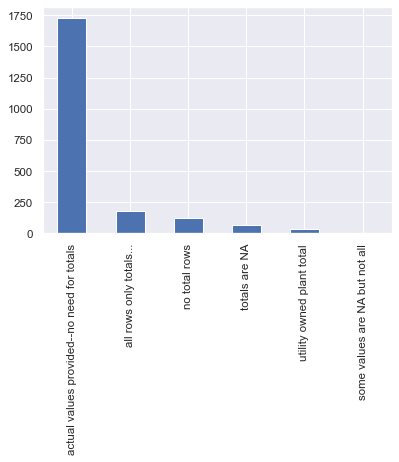

In [920]:
col_agg_df = col_agg_df.sort_values('plant_id_pudl')
#col_agg_df[col_agg_df['capex_total_flag'].str.contains('some values are NA but not all')]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
col_agg_df['capex_total_flag'].value_counts().plot(ax=ax, kind='bar')

In [921]:
for col in value_cols:
    

,report_year,utility_id_ferc1,plant_id_pudl,tech_fuel,plant_type,capex_total,capex_total_flag
1200,2007,6,16,coal,steam,1013268327.0,actual values provided--no need for totals
286,1997,6,16,coal,steam,532803192.0,actual values provided--no need for totals
1551,2011,127,16,coal,steam,988509928.0,actual values provided--no need for totals
567,2000,6,16,coal,steam,564692007.0,actual values provided--no need for totals
1317,2008,127,16,coal,steam,369549761.0,actual values provided--no need for totals
...,...,...,...,...,...,...,...
511,1999,99,11869,unknown,unknown,0.0,totals are NA
231,1996,99,11869,unknown,unknown,0.0,totals are NA
44,1994,99,11869,unknown,unknown,0.0,totals are NA
326,1997,99,11869,unknown,unknown,0.0,totals are NA


In [2430]:
col_agg_df[col_agg_df['capex_total_flag'].str.contains('all rows only')].sort_values(['plant_id_pudl', 'report_year']).plant_id_pudl.unique()
#col_agg_df[col_agg_df['avg_num_employees_flag']=='unit total']
#col_agg_df[col_agg_df['plant_id_pudl']==249]

array([  121,   249,   287,   473,   490,   497,   542,   623,   661,
        1083,  1251,  2281,  8466,  8467,  8470,  8580, 11538, 11579,
       11580, 11826])

In [917]:
mini_df(flagged_steam,249,1994,2003,['capex_total'])
#mini_df(flagged_steam,343,2008,2009, ['avg_num_employees'])
dd = flagged_steam[flagged_steam['plant_name_ferc1'].str.contains('greene')]
#dd[basic_view]
#flagged_steam[(flagged_steam['utility_id_ferc1']==2) & (flagged_steam['report_year'].isin(range(2017,2020)))][basic_view]
#flagged_steam[flagged_steam['plant_id_pudl']==8467]

In [2308]:
# Running list of fun problems:
# * If the plant total has a different plant type than the reporting utilitys' then it will come up as it's own 
#   row, probably NA :/
# * When to use total row if there are some components available
# * Unit totals - sometimes can under report (like in avg_emp 343) or over report (like in avg_emp 295)
# * 

In [1187]:
def col_aggregator(flag_df, agg_col):
    """
    Remove total rows from aggregation; use when there are nulls present in non-total rows. 
    
    This function looks at a table grouped by year, utility, and plant and determines whether to use any of the
    information from the total rows in an aggregation based on the column agg_col specified as a parameter.
    If there are no total rows, this function simply takes the sum of each group. If there are totals rows, 
    this function first looks to see if there is a utility owned total reported and then looks to see if there is
    a plant total reported.
    
    The different agg flags are:
    
    * plant total: pudl plant totals where the plant is owned by more than one utility.
    * utility owned total: all of the assets owned by a utility
    * utility owned plant total: a utility's owned portion of a pudl plant
    * utility owned plant total steam: all of the utility's steam assets within a given pudl plant
    * utility owned subtotal: the sum of several units within a pudl plant owned by one utility
    * unit total: the sum of a co-owned unit (sub-pudl plant id)
    
    If the aggregation must resort to using a total row, a flag is created and returned alongside the aggregated value.
    These values will later get split apart and set as seperate columns (in the build_col_agg_df function).
    
    Args: 
        df (pandas.DataFrame): A flagged version of the cleaned ferc1_steam table with the column name 'total_type'
            specifying wither it is a utility owned total, unit total, or plant total.
        agg_col (str): The name of the column you'd like to aggregate by.
    
    """
    
    if flag_df.loc[flag_df['total_type'].isna()][agg_col].notna().all() & len(flag_df.loc[flag_df['total_type'].isna()]) > 0: 
        flag = None
        agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
        return [agg_value, flag]
    elif flag_df['total_type'].str.contains('plant total').any() & flag_df.loc[flag_df['total_type']=='plant total'][agg_col].notna().all():
            flag = 'used plant total pertains to more than one utility'
            agg_value = flag_df.loc[flag_df['total_type']=='plant total'][agg_col].unique()[0]
            return [agg_value, flag]
    else:
        if flag_df['total_type'].str.contains('utility owned plant total').any() & flag_df.loc[flag_df['total_type']=='utility owned total'][agg_col].notna().all():
            flag = None  # 'used utility owned plant total'
            agg_value = flag_df.loc[flag_df['total_type']=='utility owned plant total'][agg_col].unique()[0]
            return [agg_value, flag]
        elif flag_df.loc[flag_df['total_type'].str.contains('utility owned plant total steam')].any() & flag_df.loc[flag_df['plant_type']=='steam'][agg_col].notna().all():
            flag = None  # 'used utility owned plant total steam'
            agg_value = flag_df.loc[flag_df['total_type'] == 'utility owned plant total steam'][agg_col].unique()[0]
        elif flag_df.loc[flag_df['total_type'].isna()][agg_col].isna().all():
            flag = None
            agg_value = np.nan
            return [agg_value, flag]
        else:
            flag = 'aggregated with some null values'
            agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
            return [agg_value, flag]

SyntaxError: invalid syntax (<ipython-input-1187-ada1f4fef60e>, line 34)

In [408]:
def build_col_agg_df(flag_df, agg_col):
    """Sort by field level.
    
    This function creates a mini aggregated dataframe based on a column specified in the parameters. 
    It runs the col_aggregator function so that the aggregations exclude total values unless there are
    gaps in the subcomponents--in which case it will first try and use a reported utility total and 
    then a plant total. The col_aggregator function returns both the aggregated value and flag to
    indicate whether it was aggregated based on a value from one of the total rows. This function turns
    the value and the flag (returned as a list within one column) to seperate columns.
    
    These column-based data aggregations can later be merged to form one large data aggregation column.
    
    Args: 
        df (pandas.DataFrame): A DataFrame....
        agg_col (str): The name of the column you'd like to aggregate by.
    Returns:
        pandas.DataFrame: A DataFrame with rows selected based on priority.
    
    """

    plant_util_group = flag_df.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl', 'primary_fuel', 'plant_type'])
    col_agg_series = plant_util_group.apply(lambda x: col_aggregator(x, agg_col))
    col_agg_df = pd.DataFrame(col_agg_series).reset_index()
    col_agg_df[[agg_col, f'{agg_col}_flag']] = pd.DataFrame(col_agg_df[0].tolist(), index=col_agg_df.index)
    col_agg_df = col_agg_df.drop(columns=[0])
    
    def combine_flags(ser):
        if ser.isna().all():
            return None
        else:
            return ', '.join([flag for flag in ser.unique() if flag != None])

    #Group by utility and fuel type
    util_fuel_df = (
        col_agg_df
        .groupby(['report_year', 'utility_id_ferc1', 'primary_fuel'])
        .agg({agg_col: 'sum',
              f'{agg_col}_flag': lambda x: combine_flags(x)})
        .reset_index()
    )
    
    return util_fuel_df

In [409]:
def aggregate_all_columns(df, col_list):
    agg_df = pd.DataFrame(columns=['report_year', 'utility_id_ferc1', 'primary_fuel'])
    for col in col_list:
        col_df = build_col_agg_df(df, col)
        agg_df = pd.merge(agg_df, col_df, on=['report_year', 'utility_id_ferc1', 'primary_fuel'], how='outer')
    return agg_df

In [410]:
complete_util_agg = aggregate_all_columns(flagged_steam, value_cols_no_cap+['capacity_mw'])

In [446]:
#complete_util_agg[complete_util_agg['primary_fuel']=='unknown']
complete_util_agg

,report_year,utility_id_ferc1,primary_fuel,net_generation_mwh,net_generation_mwh_flag,avg_num_employees,avg_num_employees_flag,capex_land,capex_land_flag,capex_equipment,...,opex_boiler,opex_boiler_flag,opex_plants,opex_plants_flag,opex_misc_steam,opex_misc_steam_flag,opex_production_total,opex_production_total_flag,capacity_mw,capacity_mw_flag
0,1994,1,coal,9.119496e+06,used utility owned total,462.0,used plant total pertains to more than one uti...,6469962.0,used utility owned total,5.300235e+08,...,6560762.0,used utility owned total,1150468.0,used utility owned total,1036572.0,used utility owned total,1.839901e+08,used utility owned total,1300.0,used utility owned total
1,1994,2,coal,5.028391e+07,None,2031.0,None,11310431.0,None,3.979206e+09,...,52555239.0,None,12821236.0,None,3462156.0,None,1.216481e+09,None,10148.0,None
2,1994,2,gas,3.388883e+06,None,154.0,None,331497.0,None,1.251836e+08,...,2866852.0,None,692054.0,None,458325.0,None,3.882226e+07,None,614.0,None
3,1994,2,nuclear,1.320825e+07,None,894.0,None,1454214.0,None,1.397899e+09,...,18601315.0,None,8937024.0,None,8814524.0,None,1.902891e+08,None,1777.0,None
4,1994,2,unknown,4.703416e+05,None,0.0,None,183261.0,None,9.493402e+07,...,1361835.0,None,252704.0,None,207816.0,None,6.494924e+06,None,115.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7738,2019,519,gas,6.447320e+05,None,16.0,None,2121938.0,None,1.539476e+08,...,0.0,None,1852337.0,None,0.0,None,1.736698e+07,None,188.0,None
7739,2019,529,coal,0.000000e+00,None,0.0,None,34510845.0,aggregated with some null values,1.483039e+09,...,0.0,None,0.0,None,0.0,None,0.000000e+00,None,0.0,aggregated with some null values
7740,2019,531,coal,1.611511e+07,None,670.0,None,10225928.0,None,3.096751e+09,...,76179710.0,None,18827008.0,None,2372785.0,None,4.756402e+08,None,3671.0,None
7741,2019,531,gas,2.469732e+06,None,42.0,None,2852666.0,None,1.135614e+09,...,658775.0,None,10723561.0,None,0.0,None,8.997181e+07,None,1224.0,None
